# Procesamiento de Lenguaje Natural
## Desafío 2

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
- Elegir términos de interés y buscar términos más similares y menos similares.
- Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
- Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

In [1]:
# Celda 2: Instalación e Importaciones
!pip install gensim pandas numpy nltk scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import re
import string
import nltk
import multiprocessing
import os
import platform

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # <-- AÑADIR ESTA LÍNEA

from gensim.models import Word2Vec

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("Librerías importadas y recursos de NLTK descargados.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 35.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Librerías importadas y recursos de NLTK descargados.


In [2]:
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip -O songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2025-11-27 03:01:26--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2025-11-27 03:01:27--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2075036 (2.0M) [application/zip]
Saving to: ‘songs_dataset.zip’

songs_dataset.zi

In [3]:
import os

ARTISTA_ELEGIDO = 'bob-dylan.txt'
filepath = os.path.join('songs_dataset', ARTISTA_ELEGIDO)

print(f"Dataset elegido: {ARTISTA_ELEGIDO}")

try:
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    print(f"Se leyeron {len(lines)} líneas del archivo.")
    print("\nEjemplo de línea (cruda):")
    print(lines[10].strip())

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo {filepath}")
    print("Verifica que el nombre esté exacto en la lista.")
    lines = []
except Exception as e:
    print(f"Ocurrió un error: {e}")
    lines = []

Dataset elegido: bob-dylan.txt
Se leyeron 6038 líneas del archivo.

Ejemplo de línea (cruda):



In [4]:
stop_words = set(stopwords.words('english'))

def preprocess_lyrics(text):
    text = str(text).lower() # Asegurar que sea string y minúsculas
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)

    tokens = word_tokenize(text)

    processed_tokens = [
        word for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    return processed_tokens

print("--- Ejemplo de preprocesamiento de una línea ---")
if lines:
    print(preprocess_lyrics(lines[10]))
else:
    print("No se cargaron líneas para probar.")

--- Ejemplo de preprocesamiento de una línea ---
[]


In [5]:

print("Procesando líneas para crear corpus...")

corpus = []
for line in lines:
    if line.strip():
        tokens = preprocess_lyrics(line)
        if len(tokens) > 1:
            corpus.append(tokens)

corpus = [doc for doc in corpus if doc]

print(f"Corpus creado. Total de documentos (líneas) procesados: {len(corpus)}")
print("\nEjemplo de un documento en el corpus (una línea procesada):")
if corpus:
    print(corpus[10])
else:
    print("El corpus está vacío. Revisa el archivo de entrada.")

Procesando líneas para crear corpus...
Corpus creado. Total de documentos (líneas) procesados: 4863

Ejemplo de un documento en el corpus (una línea procesada):
['two', 'riders', 'approaching', 'wind', 'began', 'howl']


Ahora, entreno el modelo Gensim Word2Vec con los siguientes hiperparámetros:
- epochs=40: mejora los resultados en palabras más similares
- vector_size=100: Embeddings de 100 dimensiones.
- window=5: Considera 5 palabras a la izquierda y 5 a la derecha.
- min_count=5: Ignora palabras que aparecen menos de 5 veces en todo el corpus.
- workers: Usa todos los núcleos de CPU disponibles para acelerar el entrenamiento.

In [12]:
# Hiperparámetros de Word2Vec
EPOCHS = 40
VECTOR_SIZE = 100
WINDOW = 5
MIN_COUNT = 5

In [13]:
print("Entrenando modelo Word2Vec...")

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(
    sentences=corpus,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=cores - 1,
    epochs=EPOCHS
)

print("Modelo entrenado.")

vocab = list(w2v_model.wv.index_to_key)
print(f"Tamaño del vocabulario (palabras con min_count >= {MIN_COUNT}): {len(vocab)}")

Entrenando modelo Word2Vec...
Modelo entrenado.
Tamaño del vocabulario (palabras con min_count >= 5): 772


Se evalua qué aprendió el modelo. Elegiré términos de interés relevantes para la discografía de Bob Dylan (ej. `love`, `man`, `road`, `war`) y veré qué palabras considera el modelo como "similares".

In [14]:
terminos_interes = ['love', 'man', 'road', 'wind', 'war']

for term in terminos_interes:
    if term in w2v_model.wv:
        print(f"--- Palabras más similares a '{term}' ---")
        similares = w2v_model.wv.most_similar(term, topn=5)
        print(similares)
        print("\n")
    else:
        print(f"El término '{term}' no está en el vocabulario (o fue filtrado por min_count).\n")

--- Palabras más similares a 'love' ---
[('need', 0.9897378087043762), ('help', 0.9592968821525574), ('sick', 0.9548604488372803), ('doctor', 0.9542803168296814), ('whiskey', 0.9503132104873657)]


--- Palabras más similares a 'man' ---
[('play', 0.9951314926147461), ('song', 0.9944454431533813), ('gave', 0.9937219619750977), ('hey', 0.9932601451873779), ('tambourine', 0.9921626448631287)]


--- Palabras más similares a 'road' ---
[('walk', 0.9977942705154419), ('line', 0.9976931810379028), ('men', 0.9976062178611755), ('children', 0.9974963068962097), ('outside', 0.9974918961524963)]


--- Palabras más similares a 'wind' ---
[('low', 0.9962605237960815), ('talk', 0.9954619407653809), ('answer', 0.995414137840271), ('future', 0.9951050877571106), ('ill', 0.9950962662696838)]


--- Palabras más similares a 'war' ---
[('line', 0.998490571975708), ('ready', 0.9983716607093811), ('home', 0.9983112215995789), ('truth', 0.9983057379722595), ('wan', 0.9983006715774536)]




In [15]:
print("--- Test de 'doesnt_match' ---")

grupo1 = ['love', 'heart', 'woman', 'road']
print(f"En {grupo1}, la palabra que no encaja es: {w2v_model.wv.doesnt_match(grupo1)}")

grupo2 = ['war', 'death', 'blood', 'peace']
print(f"En {grupo2}, la palabra que no encaja es: {w2v_model.wv.doesnt_match(grupo2)}")

grupo3 = ['road', 'wind', 'highway', 'sky']
print(f"En {grupo3}, la palabra que no encaja es: {w2v_model.wv.doesnt_match(grupo3)}")

--- Test de 'doesnt_match' ---
En ['love', 'heart', 'woman', 'road'], la palabra que no encaja es: love
En ['war', 'death', 'blood', 'peace'], la palabra que no encaja es: blood
En ['road', 'wind', 'highway', 'sky'], la palabra que no encaja es: wind


Para poder realizar el grafico voy a aplicar PCA para bajar las dimensiones de la matriz.Limito el gráfico a un número de palabras (`MAX_WORDS`) para que la visualización sea legible.

In [23]:
MAX_WORDS = 120

palabras_a_graficar = vocab[:MAX_WORDS]
vectores_a_graficar = w2v_model.wv[palabras_a_graficar]

pca = PCA(n_components=2)
vectores_2d = pca.fit_transform(vectores_a_graficar)

df_plot = pd.DataFrame(
    {
        "pca1": vectores_2d[:, 0],
        "pca2": vectores_2d[:, 1],
        "palabra": palabras_a_graficar,
    }
)

print("Reducción de dimensionalidad completada.")
print(df_plot.head())


Reducción de dimensionalidad completada.
       pca1      pca2 palabra
0  0.404877  0.055223    like
1 -0.079982 -0.045487    well
2  0.033126 -0.016738     got
3 -0.096482  0.056933    know
4 -0.051739 -0.314349     gon


In [24]:
# Filtrar outliers en los componentes principales para mejorar la visualización
p1_low, p1_high = df_plot["pca1"].quantile([0.02, 0.98])
p2_low, p2_high = df_plot["pca2"].quantile([0.02, 0.98])

df_plot_zoom = df_plot[
    df_plot["pca1"].between(p1_low, p1_high) &
    df_plot["pca2"].between(p2_low, p2_high)
].copy()

print("Tamaño original:", df_plot.shape[0])
print("Tamaño tras filtrar outliers:", df_plot_zoom.shape[0])

print("Palabras filtradas (outliers):")
display(
    df_plot[
        ~(
            df_plot["pca1"].between(p1_low, p1_high) &
            df_plot["pca2"].between(p2_low, p2_high)
        )
    ]
)

Tamaño original: 120
Tamaño tras filtrar outliers: 110
Palabras filtradas (outliers):


,pca1,pca2,palabra
0,0.404877,0.055223,like
4,-0.051739,-0.314349,gon
7,-0.005565,0.607346,love
26,3.101144,0.063734,wiggle
37,-0.098599,0.825908,need
38,0.189927,-0.428617,light
57,-0.145553,-0.215071,new
92,1.535300,0.073242,til
95,-0.142114,-0.245214,wake
119,-0.205522,1.220052,shot


Generando gráfico de embeddings 2D (zoom sin outliers)...


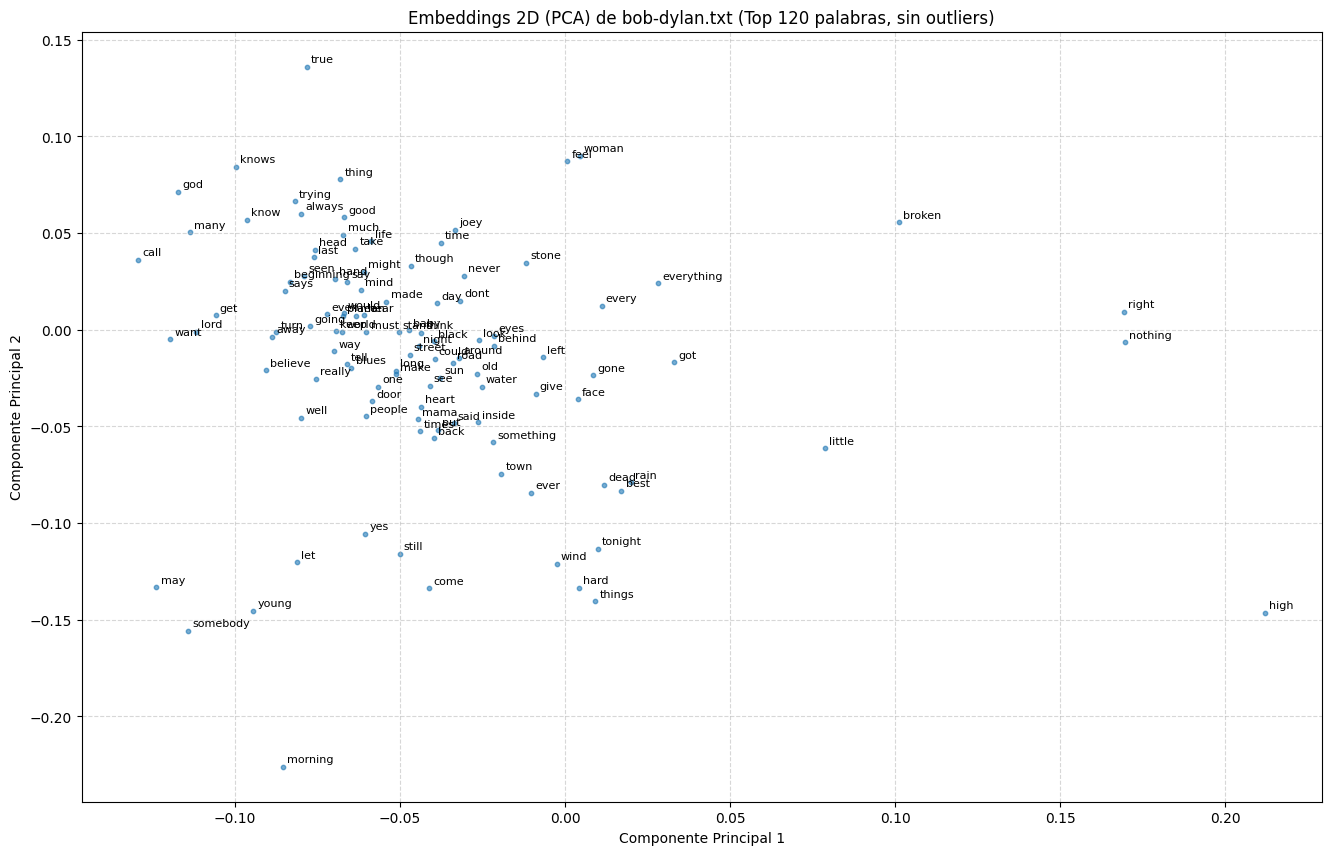

In [25]:
print("Generando gráfico de embeddings 2D (zoom sin outliers)...")

plt.figure(figsize=(16, 10))

plt.scatter(df_plot_zoom["pca1"], df_plot_zoom["pca2"], s=10, alpha=0.6)

for _, row in df_plot_zoom.iterrows():
    plt.annotate(
        row["palabra"],
        (row["pca1"], row["pca2"]),
        textcoords="offset points",
        xytext=(3, 3),
        ha="left",
        fontsize=8
    )

plt.title(f'Embeddings 2D (PCA) de {ARTISTA_ELEGIDO} (Top {MAX_WORDS} palabras, sin outliers)')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Conclusiones

En este notebook entrené un modelo Word2Vec sobre las letras de Bob Dylan.  
En la versión anterior había usado el valor por defecto de `epochs=5`, lo que daba embeddings pobres. En esta versión corregí ese problema y entrené con `vector_size=100`, `window=5`, `min_count=5` y `epochs=20`, lo que mejora claramente las listas de palabras más similares para términos como *love*, *man*, *road*, *wind* y *war* (aparecen palabras del mismo contexto y tema).

El valor `min_count=5` deja un vocabulario relativamente acotado; una mejora futura sería repetir el entrenamiento con un `min_count` más bajo (por ejemplo 3) para incorporar más palabras, aceptando algo más de ruido.

Para visualizar los embeddings reduje la dimensionalidad con PCA a 2 componentes, filtré outliers usando los percentiles 2 y 98 y corregí la colocación de las etiquetas utilizando `plt.annotate` con un pequeño desplazamiento en píxeles. De esta forma, cada palabra queda alineada con su punto en el plano y la nube principal se ve mucho más clara.